In [8]:
import torch
from meu_dataset import MeuDataset,avaliar_descritor,calcular_matching
from teste_util import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_dataset = "./data/datasets/features_path_flowers_dataset.pt"
# Carregar o dataset do arquivo "meu_dataset.pt"
meu_dataset = MeuDataset.load_from_file(path_dataset)
#verificar se o objeto meu dataset está retornando o tensor correto
assert isinstance(meu_dataset,MeuDataset), 'o tipo de retorno não é MeuDataset'
assert isinstance(meu_dataset[0][0],torch.Tensor), 'o tipo de retorno não é torch.Tensor'


In [9]:
import gc
from torch.optim.lr_scheduler import ExponentialLR
gc.collect()
torch.cuda.empty_cache()
batch_size_siam = 100
from torch.utils.data import random_split, DataLoader

train_dataset, val_dataset, test_dataset = random_split(meu_dataset, [0.3,0.5,0.2])
# Crie uma instância do DataLoader usando seu conjunto de dados personalizado
dataloader_val = DataLoader(val_dataset, batch_size=batch_size_siam, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size_siam, shuffle=True)

In [22]:
import torch
import torch.nn as nn
from e2cnn import gspaces
from e2cnn import nn as enn
import matplotlib.pyplot as plt

class CustomDescriptorModule(nn.Module):
    def __init__(self, in_channels, output_size=(32, 32)):
        super(CustomDescriptorModule, self).__init__()

        r2_act = gspaces.Rot2dOnR2(N=36)  # Substitua N pelo número correto de rotações

        feat_type_in = enn.FieldType(r2_act,  [r2_act.trivial_repr] * in_channels)
        feat_type_out = enn.FieldType(r2_act, [r2_act.regular_repr] * 16)  # Substitua 16 pelo número correto

        self.block1 = enn.SequentialModule(
            enn.R2Conv(feat_type_in, feat_type_out, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(feat_type_out),
            enn.ReLU(feat_type_out, inplace=True),
            enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.22, stride=1, padding=0),
        )

        feat_type_in = feat_type_out
        feat_type_out = enn.FieldType(r2_act, [r2_act.regular_repr] * 6)  # Substitua 16 pelo número correto

        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_in, feat_type_out, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(feat_type_out),
            enn.ReLU(feat_type_out, inplace=True),
            enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.22, stride=1, padding=0),
        )
        
        fc_input_size = feat_type_out.size
        self.fc = nn.Linear(fc_input_size, 128)
        self.gpool = enn.GroupPooling(feat_type_out)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.block1.in_type)
        n_dim = x.tensor.shape[-1]
        mask = enn.MaskModule(self.block1.in_type, n_dim, margin=5)
        x = mask(x)
        x = self.block1(x)
        x = self.block2(x)
        # x = enn.GeometricTensor(x, self.fc.in_features)
        # x = self.fc(x.tensor)
        x = self.gpool(x)
        return x.tensor

model = CustomDescriptorModule(3).to('cpu')
img = torch.rand(1, 3, 32, 32)
out = model(img)
print(out.shape)


def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]  # Número de imagens
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()

torch.Size([1, 6, 28, 28])


In [23]:
import torch
from ipywidgets import interact, widgets  # Importe os widgets interativos
from kornia.geometry.transform import Rotate

model = CustomDescriptorModule(8)
img = meu_dataset[0][0][None, ...]

# Função de interação para controlar o ângulo de rotação
@interact(angle=widgets.FloatSlider(min=-180, max=180, value=0.0, step=1.0))
def interact_rotation(angle):
    angle = torch.tensor(angle)
    img_r = Rotate(angle)(img)
    
    
    out = model(img)
    out_r = model(img_r)
    print(out.shape,out_r.shape)
    
    plot_patches_side_by_side(img[0])
    plot_patches_side_by_side(out[0])
    plot_patches_side_by_side(out_r[0])
    plot_patches_side_by_side(Rotate(-angle)(out_r)[0])
    print(out.shape)


interactive(children=(FloatSlider(value=0.0, description='angle', max=180.0, min=-180.0, step=1.0), Output()),…

In [24]:
import torch
import cv2
import numpy as np

def calculate_edge_orientation_histogram(image_tensor):
    # Converter o tensor para uma imagem em escala de cinza (se necessário)
    if image_tensor.dim() == 3 and image_tensor.size(0) == 3:
        image_tensor = torch.mean(image_tensor, dim=0, keepdim=True)

    # Converter o tensor PyTorch para uma matriz NumPy
    image_np = image_tensor.cpu().numpy()

    # Aplicar o detector de bordas Canny
    edges = cv2.Canny(image_np[0], threshold1=30, threshold2=100)

    # Calcular os gradientes em x e y usando Sobel
    gradient_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular as orientações das bordas
    edge_orientations = np.arctan2(gradient_y, gradient_x)
    edge_orientations = np.degrees(edge_orientations) % 180  # Converter para graus e normalizar

    # Calcular o histograma de orientações
    hist, bins = np.histogram(edge_orientations, bins=9, range=(0, 180))

    # Normalizar o histograma (opcional)
    hist = hist / hist.sum()

    return hist

# Criar um tensor de exemplo (substitua isso pelo seu próprio tensor de imagem)
# Aqui, estamos criando um tensor de exemplo com valores aleatórios entre 0 e 255
example_tensor = torch.randint(0, 256, size=(3, 256, 256), dtype=torch.uint8)

# Calcular o histograma usando o tensor de exemplo
histogram = calculate_edge_orientation_histogram(example_tensor)
print(histogram)


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Byte

In [5]:
import torch
import torch.nn.functional as F

def create_circular_mask(width, height, center=None, radius=None):
    if center is None:
        center = (width // 2, height // 2)
    if radius is None:
        radius = min(center[0], center[1], width - center[0], height - center[1])

    x = torch.arange(width, dtype=torch.float32)
    y = torch.arange(height, dtype=torch.float32)
    xx, yy = torch.meshgrid(x, y)

    distance = torch.sqrt((xx - center[0])**2 + (yy - center[1])**2)

    mask = (distance <= radius).float()
    return mask

# Tamanho da imagem
width, height = 32, 32

# Diâmetro do círculo
diameter = 32

# Criar a máscara circular
mask = create_circular_mask(width, height, radius=diameter / 2)

/home/wagner/.local/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


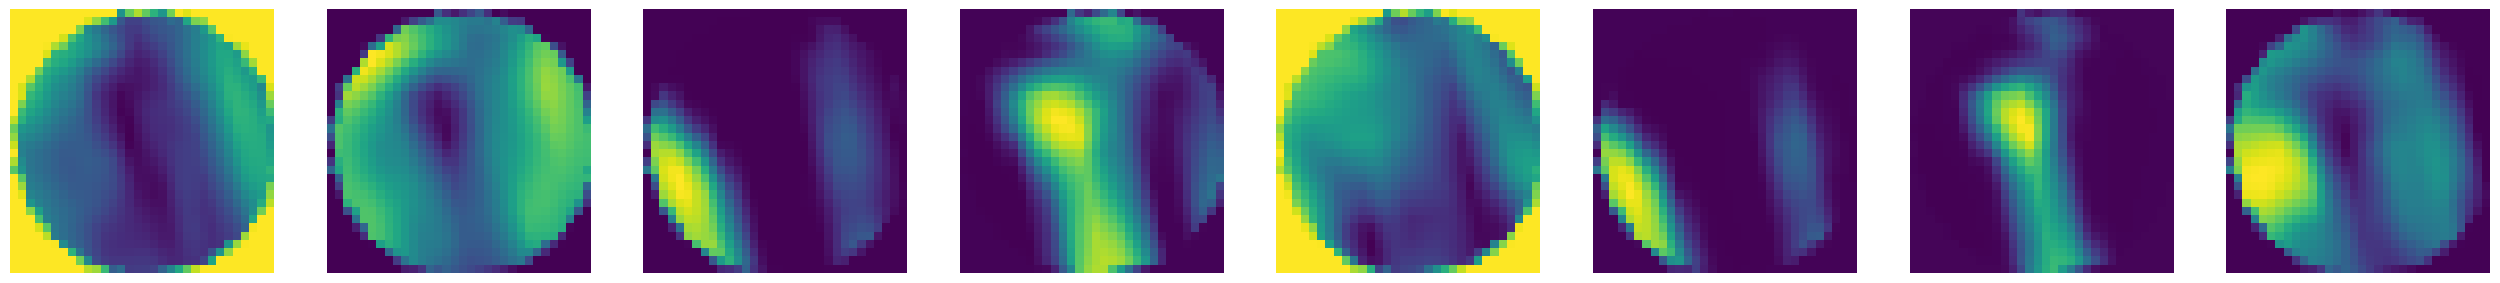

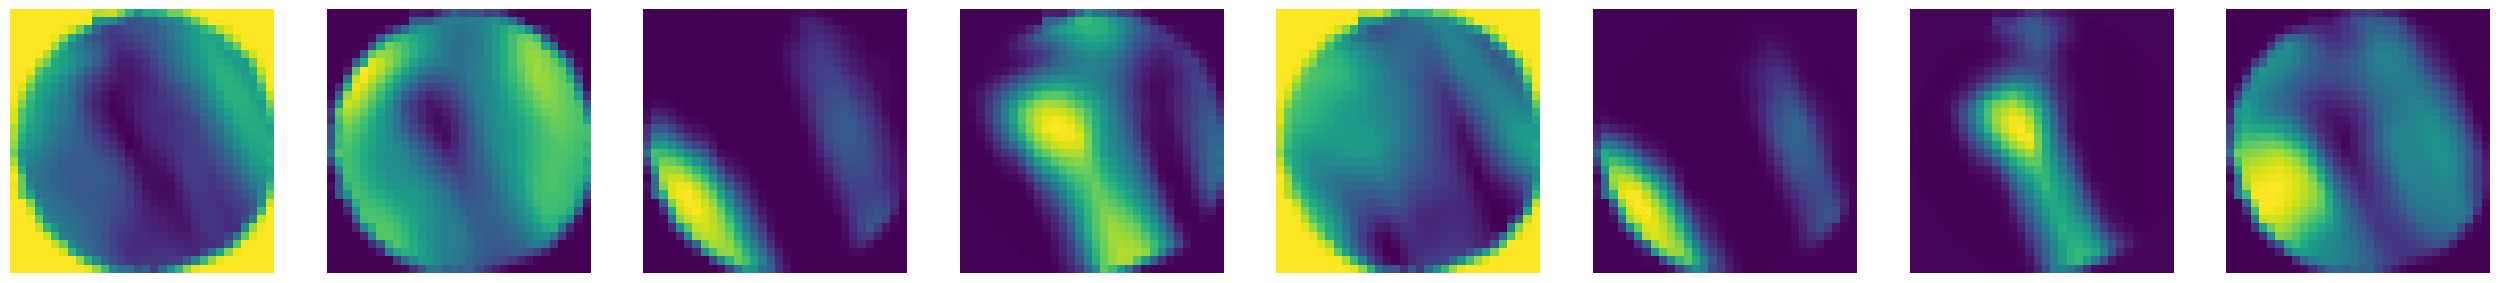

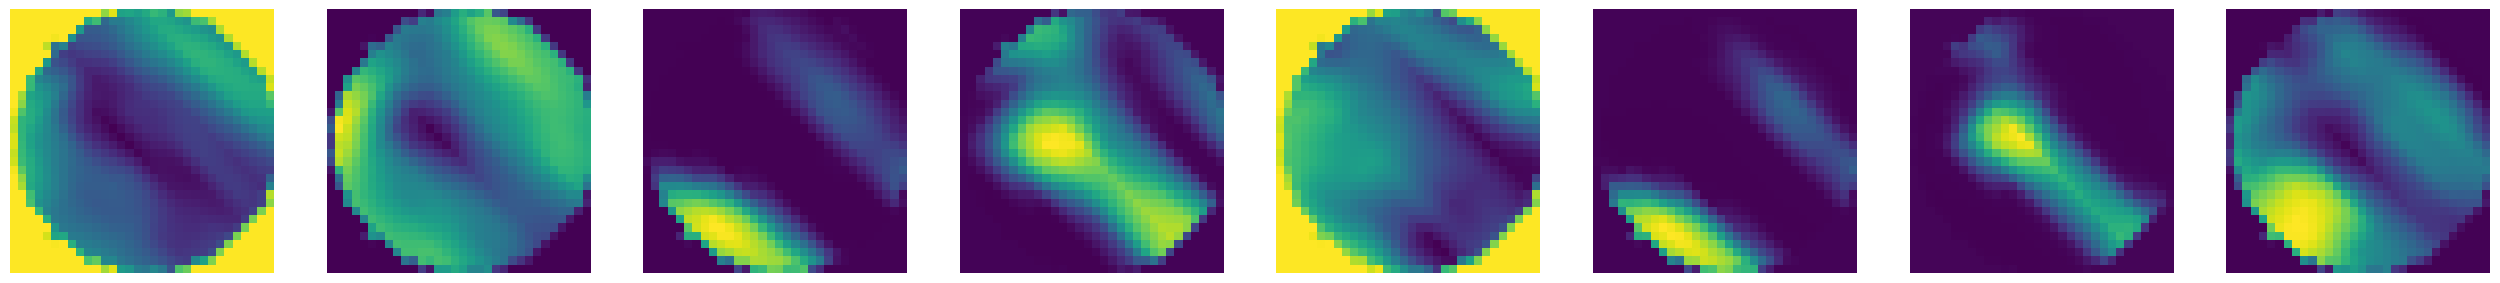

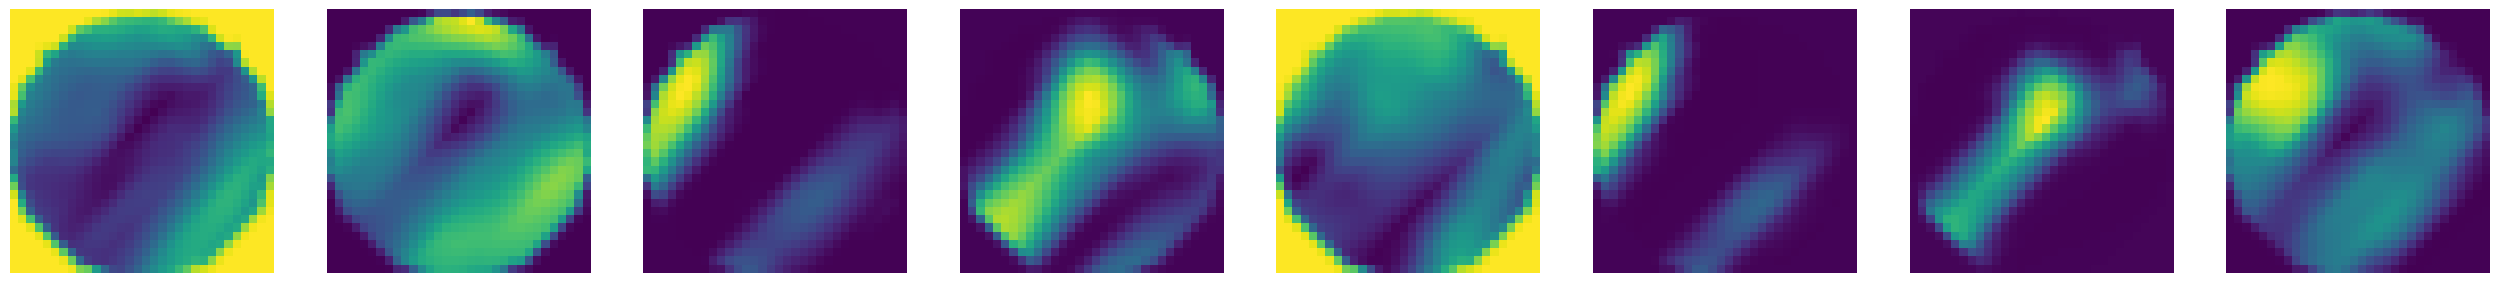

In [6]:
import torch
import kornia
from kornia.feature import OriNet
orinet = OriNet(pretrained=True).eval()

# Defina as configurações desejadas
patch_size = 32
num_angular_bins = 18
eps = 1e-8

patch_gradient_orientation = kornia.feature.PatchDominantGradientOrientation(patch_size, num_angular_bins, eps)



def alinha_patch(patch):
    B, C, H, W = patch.shape
    new_patches = patch.reshape(B*C, 1, H, W)
    orientation_degree = patch_gradient_orientation(new_patches)*(180.0 / math.pi)
    orientation_degree = orientation_degree.reshape(B,C)
    degree = torch.mean(orientation_degree,dim=1)
    patch = Rotate(degree)(patch)
    return patch

# Crie uma instância da classe PatchDominantGradientOrientation


# Simule um lote de patches
patches = meu_dataset[0][0][None]*mask
B, C, H, W = patches.shape

patches_r= Rotate(torch.tensor(10.))(patches)
patches_o =alinha_patch(patches_r)
plot_patches_side_by_side(patches_r.reshape(B*C,H, W))
plot_patches_side_by_side(patches_o.reshape(B*C,H, W))

patches_r= Rotate(torch.tensor(45.))(patches)
patches_o =alinha_patch(patches_r)
plot_patches_side_by_side(patches_r.reshape(B*C,H, W))
plot_patches_side_by_side(patches_o.reshape(B*C,H, W))



In [7]:
model.to(device).eval()
with torch.no_grad():
    total_acertos,total_erros,total_elementos = avaliar_descritor(dataloader_test, model,th=0.5)
sub_conjunto = total_elementos//2
print(f'Total de elementos no DataLoader: {total_elementos}')
print(f'Acertei: {total_acertos}/{sub_conjunto} Errei: {total_erros}/{sub_conjunto}')

  0%|          | 0/13 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:

from tqdm import tqdm

    
progress_bar = tqdm(dataloader_test)
for idx, data in enumerate(progress_bar):
    # extrair as features e orientações
    batch_in, batch_out = data[0].to(device), data[1].to(device)
    print(batch_in.shape)
    plot_patches_side_by_side(batch_in[:20,0])
    plot_patches_side_by_side(batch_out[:20,0])
    